# Support points with Exponential Mechanism: Greedy method

### Procedure:


1. Given data $X = \{x_1, \ldots, x_M\}$ on space $\mathcal{D} \in [0, 1]^d$, find optimal support points $Y = \{y_1, \ldots, y_N\}$.
2. Using energy distance (with Lp norm) as the score function of the exponential mechanism, the sensitivity is $\Delta f = \frac{2 d^{1/p}(2N - 1)}{N^2}$. The exponential mechanism samples a new energy value $\tilde{e} \sim \mbox{Exp}(\frac{2\Delta f}{\alpha})$, where $\alpha$ is the privacy budget.
3. Let $\tilde{Y}$ be a copy of $Y$. Sample new $\tilde{Y}$ by Metropolis Hastings, using randomly perturbed versions of $\tilde{Y}$ as proposals, and using energy to compute the acceptance ratio.

---

 
Note: Exponential samples (i.e. energy distances) are larger with:
  - small privacy budget, $\alpha$
  - large sensitivity, $\Delta f$
  - large dimensionality, $d$
  - small energy exponent, $p$
  - small support point set, $N$.

___

# 0. Helper Functions

In [1]:
%matplotlib inline

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pdb
from scipy.spatial.distance import pdist
import sys
import tensorflow as tf
import time

from data import load_balog_data
from sp_utils import (
    get_support_points,
    get_energy_sensitivity,
    greedy_sp_exp_mech,
    energy,
    sample_sp_exp_mech,
    mixture_model_likelihood,
    sample_full_set_given_bandwidth)

matplotlib.rcParams.update({'font.size': 14})
plt.style.use('ggplot')
print(sys.version)
print(tf.__version__)

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
1.13.1


____

# 1. Global Config

Note: Exponential samples (i.e. energy distances) are smaller with:
  - large privacy budget, $\alpha$
  - small sensitivity, $\Delta f$
  - small dimensionality, $d$
  - large energy exponent, $p$
  - large support point set, $N$

In [2]:
# Set global constants.          # main1()
IS_TF = True                     # Boolean. Use TensorFlow rather than analytical gradients.
Y_INIT_OPTION = 'random'         # ['grid', 'random', 'radial']
MAX_ITER = 301                   # Num iterations in each support point optimization. [301]
LR = 1e-2                        # Energy optimization learning rate. [1e-2]

NUM_DATA = 200                   # Number of data points. [200]\
DIM = 2                          # Dimension of data. [2]
C = 10                           # Number of clusters in data. [10]
SIGMA_DATA = 0.03                # Bandwidth of data. [0.03]

NUM_SUPP = 10                    # Number of support points. [10]
ENERGY_POWER = 2                # Power for energy distance kernel. [2]

___

# 2. Load Data

In [3]:
# Load data.
np.random.seed(123)
x = load_balog_data(NUM_DATA, DIM, C, SIGMA_DATA, make_new=True, do_weighted=True)
#x = np.load('../../RKHS-private-database/data/mixture_of_Gaussians_N1000_D2_C10_SIG0.03.npz')['X_private']
print(x.shape)

Loaded M=200, DIM=2, SIG=0.03, C=10
(200, 2)


___

# 3. Run Support Point Optimization


STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0188


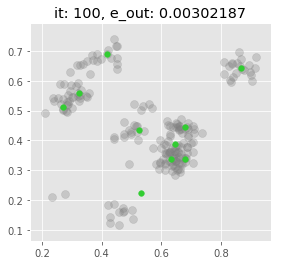

  [*] Overall it/s: 0.0164


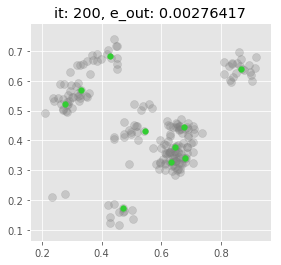

  [*] Overall it/s: 0.0158


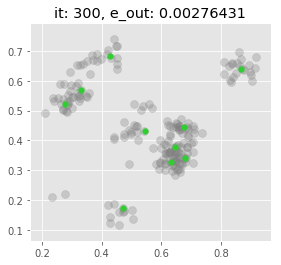

  [*] Time elapsed: 4.82


In [4]:
# Compute m support points on full set.
y_opt, e_opt = get_support_points(x, NUM_SUPP, MAX_ITER, LR, is_tf=IS_TF,
                                  power=ENERGY_POWER, y_init_option=Y_INIT_OPTION)  # NOTE: Power=2 to derive optimal SP.

# 4. Greedy support points

## 4.0 greedy support points with exponential mechanism

energy sensitivity: 0.02821356056934325

 Total alpha = 5000, split over K=10 steps
Per-step distribution: Pr(e) = a / (2UK) * exp(- a / (2UK) * e) ~ Exp(2UK/a) = Exp(2 * 0.0282* 10 / 5000.000) = Exp(0.00011285)



/Users/swilliamson/Work/Mo/pv/mv_sp_privacy/src/sp_utils.py:437: RuntimeWarning: divide by zero encountered in power
  term1 = c1 * np.sum(pairwise_difs ** power, axis=2) ** (c1 - 1)


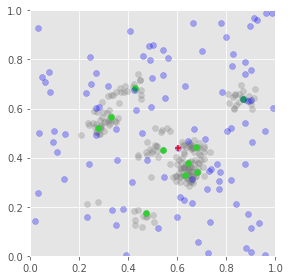

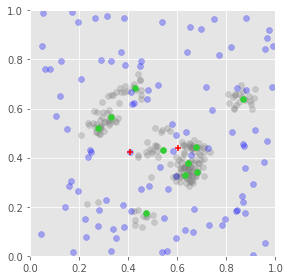

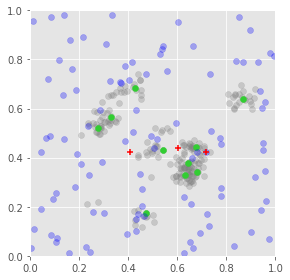

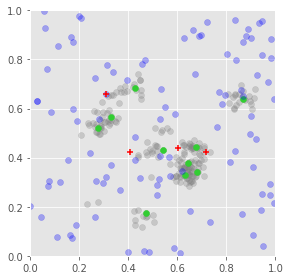

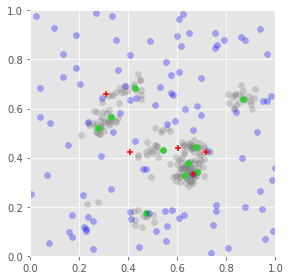

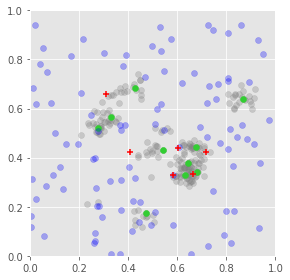

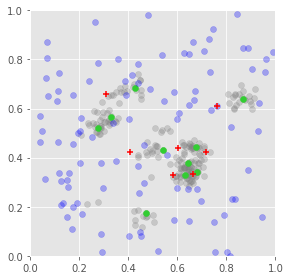

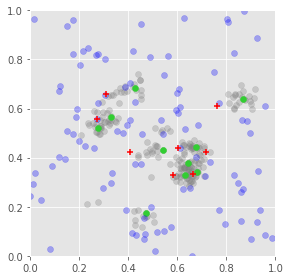

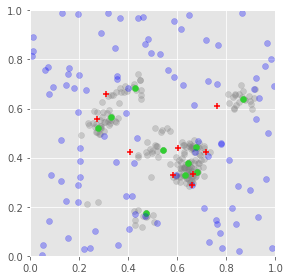

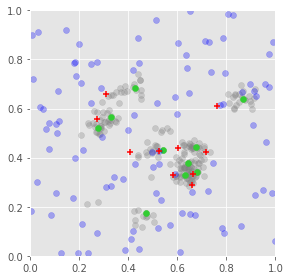

time taken: 7.882440090179443


In [5]:
# First, with visualization: blue are the candidate points, red are the greedily chosen points
ALPHA = 5000  # 10000
# Define energy sensitivity for Exponential Mechanism.
N, D = x.shape
energy_sensitivity = get_energy_sensitivity(N, D, power=ENERGY_POWER)

print('energy sensitivity: {}'.format(energy_sensitivity))
tic = time.time()
support_points = greedy_sp_exp_mech(energy_sensitivity=energy_sensitivity, 
                                    data=x, 
                                    num_support_points=NUM_SUPP,
                                   alpha=ALPHA, 
                                    num_candidate_points=100, power=ENERGY_POWER, set_seed=True,
                                   optimal_support_points=y_opt,
                                   plot=True)

toc = time.time()
print('time taken: {}'.format(toc-tic))


In [6]:
## next, let's build up datasets for 3 different privacy values, with 30 samples each

NUM_Y_TILDES = 30 
ALPHA_VALS = [50, 500, 5000]
NUM_CANDIDATE = 100

energy_sensitivity = get_energy_sensitivity(N, D, power=ENERGY_POWER)
print('energy sensitivity: {}'.format(energy_sensitivity))

greedy_support_points = {}
greedy_energies = {}
np.random.seed(123)
for ALPHA in ALPHA_VALS:
    
    print('starting ALPHA={}'.format(ALPHA))
    greedy_support_points[ALPHA] = []
    greedy_energies[ALPHA] = []
    for n in range(NUM_Y_TILDES):
        support_points = greedy_sp_exp_mech(energy_sensitivity=energy_sensitivity, 
                                            data=x, 
                                            num_support_points=NUM_SUPP,
                                            alpha=ALPHA, 
                                            num_candidate_points=NUM_CANDIDATE, 
                                            power=ENERGY_POWER, 
                                            set_seed=False)
        en, _ = energy(support_points, x, power=ENERGY_POWER)
        greedy_support_points[ALPHA].append(support_points)
        greedy_energies[ALPHA].append(en)


energy sensitivity: 0.02821356056934325
starting ALPHA=50

 Total alpha = 50, split over K=10 steps
Per-step distribution: Pr(e) = a / (2UK) * exp(- a / (2UK) * e) ~ Exp(2UK/a) = Exp(2 * 0.0282* 10 / 50.000) = Exp(0.01128542)


 Total alpha = 50, split over K=10 steps
Per-step distribution: Pr(e) = a / (2UK) * exp(- a / (2UK) * e) ~ Exp(2UK/a) = Exp(2 * 0.0282* 10 / 50.000) = Exp(0.01128542)


 Total alpha = 50, split over K=10 steps
Per-step distribution: Pr(e) = a / (2UK) * exp(- a / (2UK) * e) ~ Exp(2UK/a) = Exp(2 * 0.0282* 10 / 50.000) = Exp(0.01128542)


 Total alpha = 50, split over K=10 steps
Per-step distribution: Pr(e) = a / (2UK) * exp(- a / (2UK) * e) ~ Exp(2UK/a) = Exp(2 * 0.0282* 10 / 50.000) = Exp(0.01128542)


 Total alpha = 50, split over K=10 steps
Per-step distribution: Pr(e) = a / (2UK) * exp(- a / (2UK) * e) ~ Exp(2UK/a) = Exp(2 * 0.0282* 10 / 50.000) = Exp(0.01128542)


 Total alpha = 50, split over K=10 steps
Per-step distribution: Pr(e) = a / (2UK) * exp(- a / (2


 Total alpha = 500, split over K=10 steps
Per-step distribution: Pr(e) = a / (2UK) * exp(- a / (2UK) * e) ~ Exp(2UK/a) = Exp(2 * 0.0282* 10 / 500.000) = Exp(0.00112854)


 Total alpha = 500, split over K=10 steps
Per-step distribution: Pr(e) = a / (2UK) * exp(- a / (2UK) * e) ~ Exp(2UK/a) = Exp(2 * 0.0282* 10 / 500.000) = Exp(0.00112854)


 Total alpha = 500, split over K=10 steps
Per-step distribution: Pr(e) = a / (2UK) * exp(- a / (2UK) * e) ~ Exp(2UK/a) = Exp(2 * 0.0282* 10 / 500.000) = Exp(0.00112854)


 Total alpha = 500, split over K=10 steps
Per-step distribution: Pr(e) = a / (2UK) * exp(- a / (2UK) * e) ~ Exp(2UK/a) = Exp(2 * 0.0282* 10 / 500.000) = Exp(0.00112854)


 Total alpha = 500, split over K=10 steps
Per-step distribution: Pr(e) = a / (2UK) * exp(- a / (2UK) * e) ~ Exp(2UK/a) = Exp(2 * 0.0282* 10 / 500.000) = Exp(0.00112854)


 Total alpha = 500, split over K=10 steps
Per-step distribution: Pr(e) = a / (2UK) * exp(- a / (2UK) * e) ~ Exp(2UK/a) = Exp(2 * 0.0282* 10 / 50

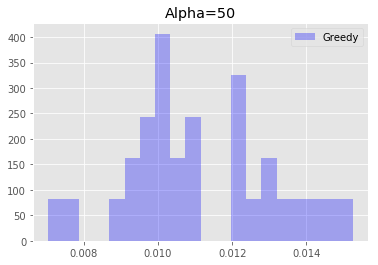

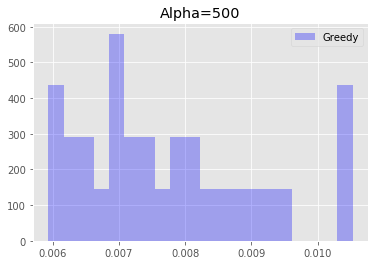

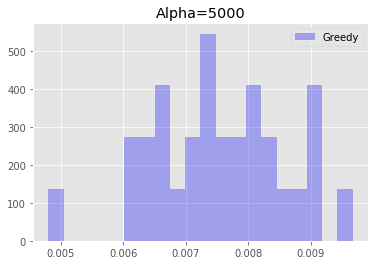

In [7]:
plt.hist(greedy_energies[50], bins=20, alpha=0.3, density=True, color='b', label='Greedy')
plt.legend()
plt.title('Alpha=50')
plt.show()

plt.hist(greedy_energies[500], bins=20, alpha=0.3, density=True, color='b', label='Greedy')
plt.legend()
plt.title('Alpha=500')
plt.show()

plt.hist(greedy_energies[5000], bins=20, alpha=0.3, density=True, color='b', label='Greedy')
plt.legend()
plt.title('Alpha=5000')
plt.show()

### Note, the distribution is similar with larger numbers of candidate points (I tried 100 and 500)

# 5. Sample support points

## 5.0 Sample support points with Exponential Mechanism, based on original data

energy sensitivity: 0.02821356056934325

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.0282 / 50.000) = Exp(0.00112854)

Running chain. Length=65000, Burn=5000, Thin=2000
Difference factor: 886.10

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: -0.00090155


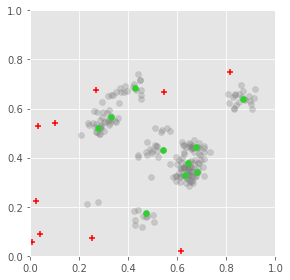

acceptance_rate=0.30179972, step_size=0.25000000
Energy diff: 0.00547199


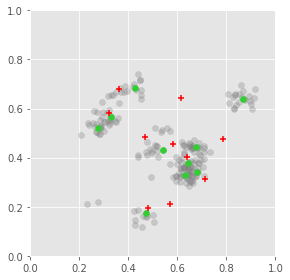

acceptance_rate=0.30066918, step_size=0.17694720
Energy diff: 0.00968713


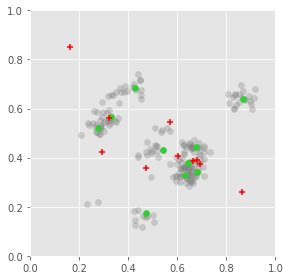

acceptance_rate=0.30162556, step_size=0.18786187
Energy diff: 0.00527732


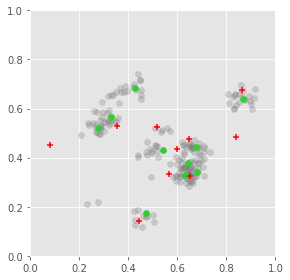

acceptance_rate=0.30068074, step_size=0.07864320
Energy diff: -0.00010169


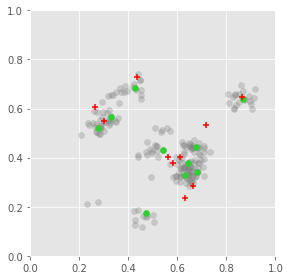

acceptance_rate=0.30079074, step_size=0.16986931
Energy diff: 0.00102857


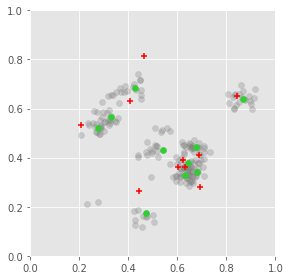

acceptance_rate=0.30017179, step_size=0.25000000
Energy diff: 0.01748321


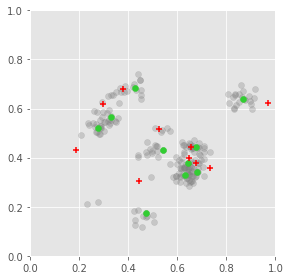

acceptance_rate=0.30118019, step_size=0.18786187
Energy diff: 0.00130784


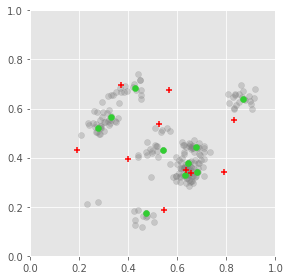

acceptance_rate=0.30005192, step_size=0.22118400
Energy diff: 0.01407541


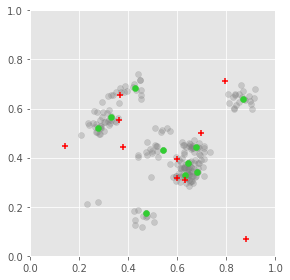

acceptance_rate=0.30025128, step_size=0.21233664
Energy diff: 0.00428687


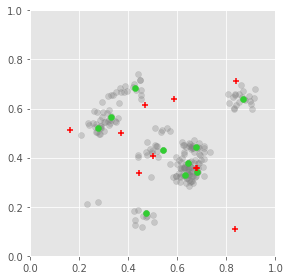

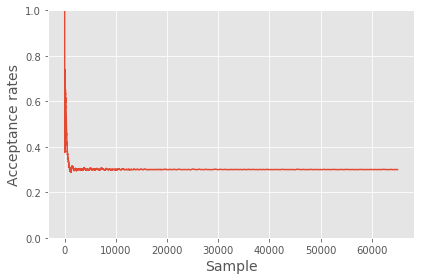

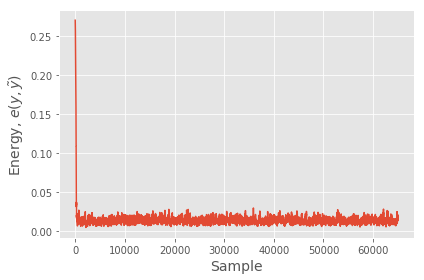

Acceptance rate: 0.300
percent steps that improved energy score: 0.151


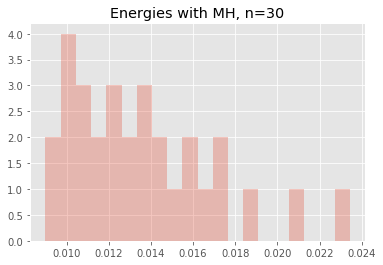


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.0282 / 500.000) = Exp(0.00011285)

Running chain. Length=65000, Burn=5000, Thin=2000
Difference factor: 8860.99

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: -0.00090155


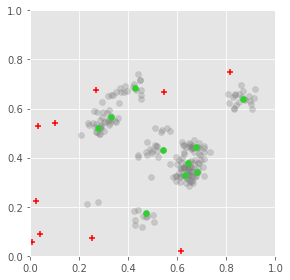

acceptance_rate=0.31195201, step_size=0.21582150
Energy diff: 0.00690170


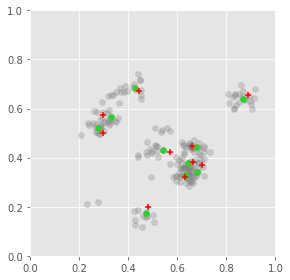

acceptance_rate=0.29628490, step_size=0.01099512
Energy diff: 0.00036181


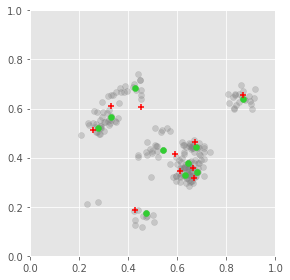

acceptance_rate=0.30393313, step_size=0.06535571
Energy diff: 0.00079997


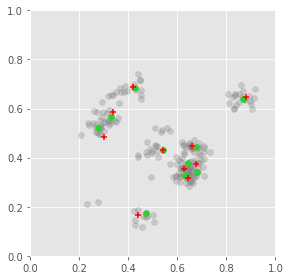

acceptance_rate=0.29625784, step_size=0.04194304
Energy diff: 0.00006194


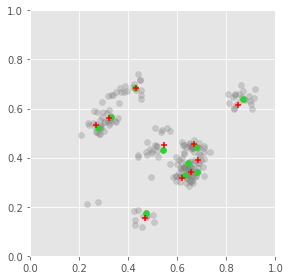

acceptance_rate=0.30174456, step_size=0.00810648
Energy diff: -0.00007785


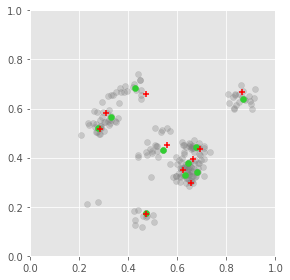

acceptance_rate=0.30299223, step_size=0.03025727
Energy diff: 0.00148098


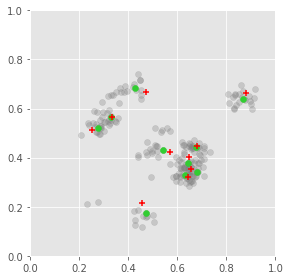

acceptance_rate=0.30249885, step_size=0.10408058
Energy diff: 0.00210357


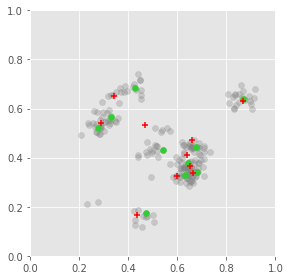

acceptance_rate=0.30059037, step_size=0.25000000
Energy diff: 0.01337207


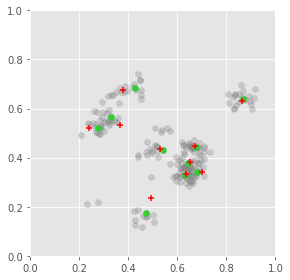

acceptance_rate=0.29869575, step_size=0.06553600
Energy diff: 0.00031037


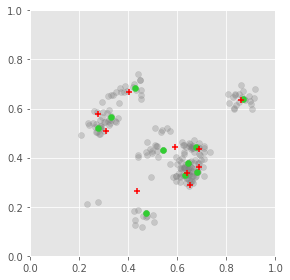

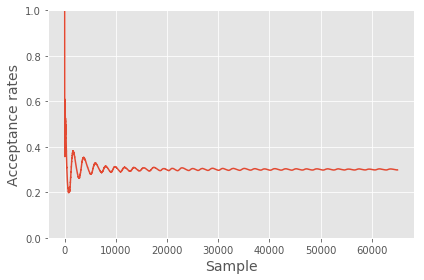

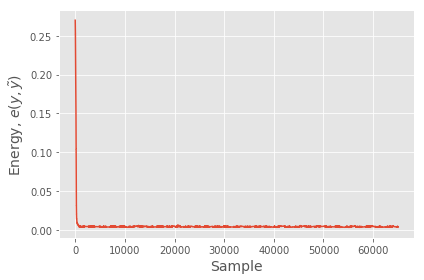

Acceptance rate: 0.299
percent steps that improved energy score: 0.151


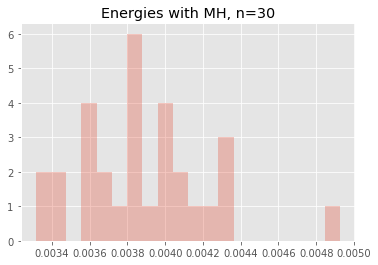


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.0282 / 5000.000) = Exp(0.00001129)

Running chain. Length=65000, Burn=5000, Thin=2000
Difference factor: 88609.87

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: -0.00090155


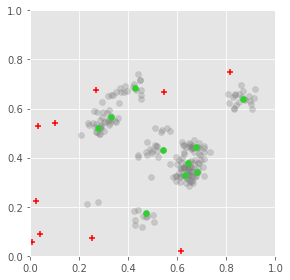

acceptance_rate=0.32195047, step_size=0.00282018
Energy diff: 0.00000481


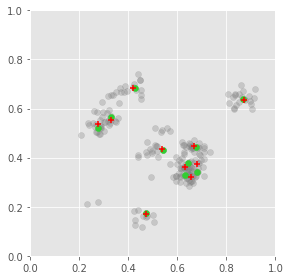

acceptance_rate=0.31951388, step_size=0.02896707
Energy diff: 0.00028636


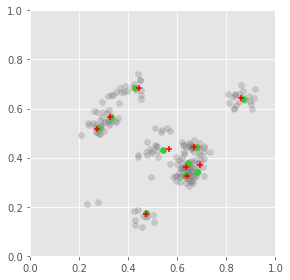

acceptance_rate=0.29875391, step_size=0.14946373
Energy diff: 0.00213143


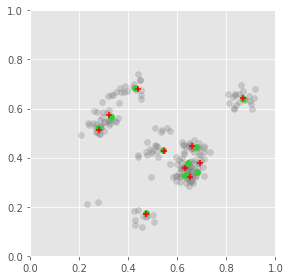

acceptance_rate=0.29248875, step_size=0.01099512
Energy diff: 0.00000457


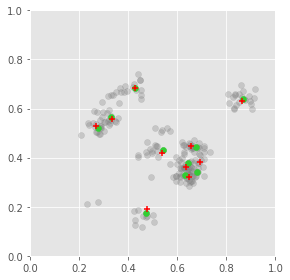

acceptance_rate=0.30374450, step_size=0.00156677
Energy diff: -0.00000093


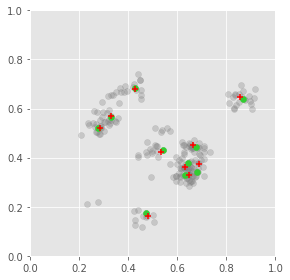

acceptance_rate=0.30581267, step_size=0.00701752
Energy diff: 0.00006686


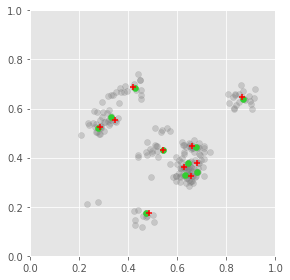

acceptance_rate=0.30166370, step_size=0.10811902
Energy diff: 0.00148607


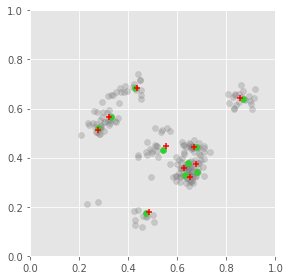

acceptance_rate=0.29737890, step_size=0.02684355
Energy diff: 0.00080228


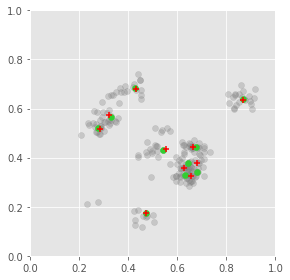

acceptance_rate=0.29955044, step_size=0.00094447
Energy diff: -0.00000080


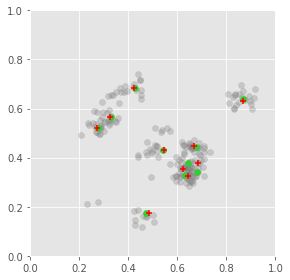

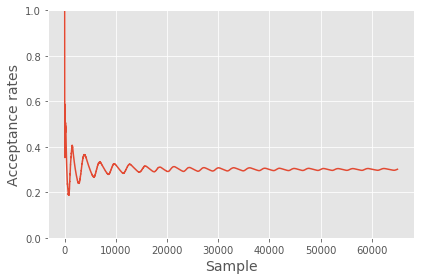

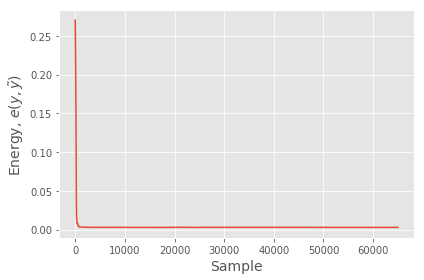

Acceptance rate: 0.301
percent steps that improved energy score: 0.152


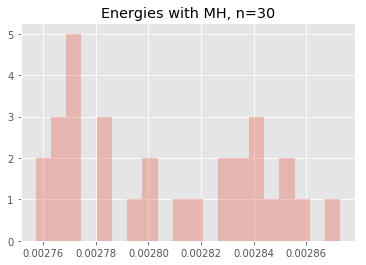

In [14]:
# Sampling parameters.
NUM_Y_TILDES = 30 
ALPHA_VALS = [50, 500, 5000]

energy_sensitivity = get_energy_sensitivity(N, D, power=ENERGY_POWER)

print('energy sensitivity: {}'.format(energy_sensitivity))

sample_direct_support_points = {}
sample_direct_energies = {}
save_dir = '/Users/swilliamson/Work/Mo/pv/mv_sp_privacy/output'
for ALPHA in ALPHA_VALS:
    (y_tildes_full_data,
     energies_full_data,
     _) = sample_sp_exp_mech(energy_sensitivity=energy_sensitivity, 
                             data=x, 
                             num_support_points = NUM_SUPP, 
                             method='mh', 
                             num_y_tildes=NUM_Y_TILDES,
                             alpha=ALPHA, 
                             plot=1, 
                             save_dir=save_dir, 
                             power=ENERGY_POWER,
                             set_seed=True,
                             optimal_support_points=y_opt
                            )
    sample_direct_support_points[ALPHA] = y_tildes_full_data
    sample_direct_energies[ALPHA] = energies_full_data
 

In [ ]:
plt.hist(sample_direct_energies[50], bins=20, alpha=0.3, density=True, color='r', label='Full data')
plt.hist(greedy_energies[50], bins=20, alpha=0.3, density=True, color='b', label='Greedy')
plt.legend()
plt.title('Alpha=50')
plt.show()

plt.hist(sample_direct_energies[500], bins=20, alpha=0.3, density=True, color='r', label='Full data')
plt.hist(greedy_energies[500], bins=20, alpha=0.3, density=True, color='b', label='Greedy')
plt.legend()
plt.title('Alpha=500')
plt.show()

plt.hist(sample_direct_energies[5000], bins=20, alpha=0.3, density=True, color='r', label='Full data')
plt.hist(greedy_energies[5000], bins=20, alpha=0.3, density=True, color='b', label='Greedy')
plt.legend()
plt.title('Alpha=5000')
plt.show()

## 5.1 Sample support points with Exponential Mechanism, based on pre-selected support points


energy sensitivity: 0.5374011537017761

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 50.000) = Exp(0.02149605)

Running chain. Length=65000, Burn=5000, Thin=2000
Difference factor: 46.52

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: 0.00131426


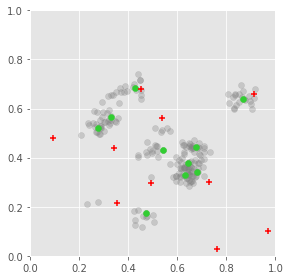

acceptance_rate=0.80756807, step_size=0.25000000
Energy diff: 0.02209748


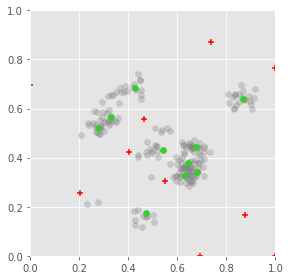

acceptance_rate=0.79932313, step_size=0.25000000
Energy diff: 0.02815644


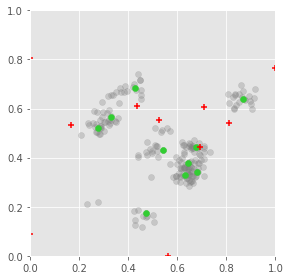

acceptance_rate=0.80042049, step_size=0.25000000
Energy diff: -0.00941737


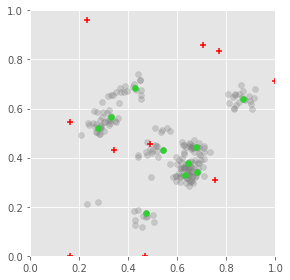

acceptance_rate=0.79954617, step_size=0.25000000
Energy diff: -0.00154445


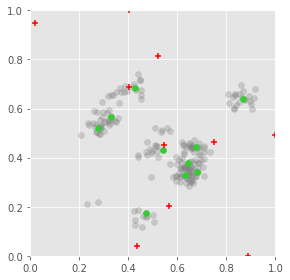

acceptance_rate=0.79908311, step_size=0.25000000
Energy diff: 0.01146165


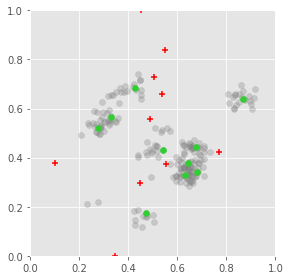

acceptance_rate=0.80151791, step_size=0.25000000
Energy diff: 0.02280161


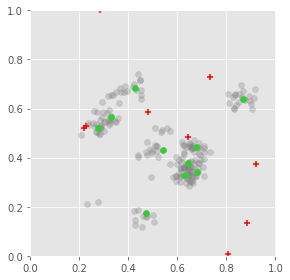

acceptance_rate=0.80154282, step_size=0.25000000
Energy diff: -0.00963081


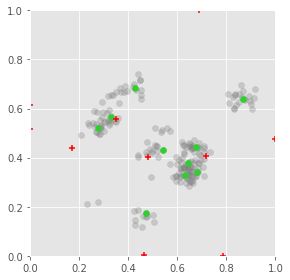

acceptance_rate=0.80021538, step_size=0.25000000
Energy diff: 0.00017519


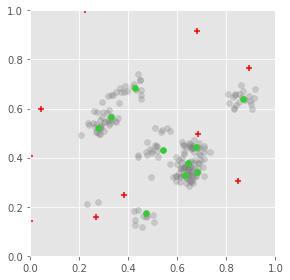

acceptance_rate=0.79962736, step_size=0.25000000
Energy diff: 0.00624601


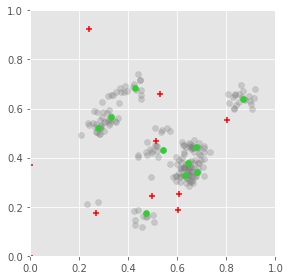

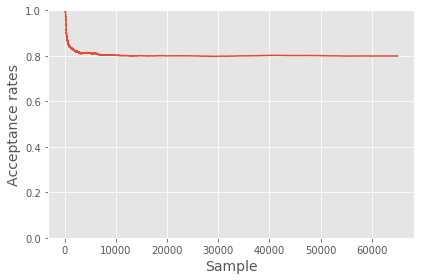

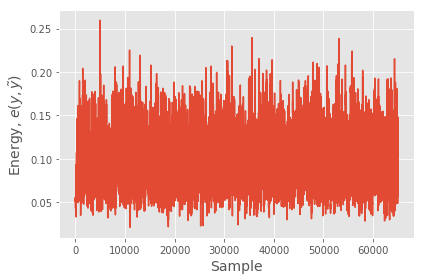

Acceptance rate: 0.799
percent steps that improved energy score: 0.391


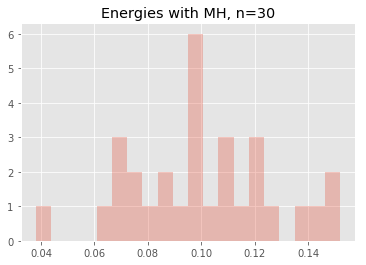


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 500.000) = Exp(0.00214960)

Running chain. Length=65000, Burn=5000, Thin=2000
Difference factor: 465.20

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: -0.00087300


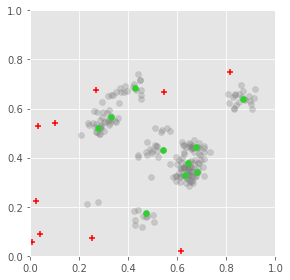

acceptance_rate=0.33548685, step_size=0.25000000
Energy diff: -0.00484740


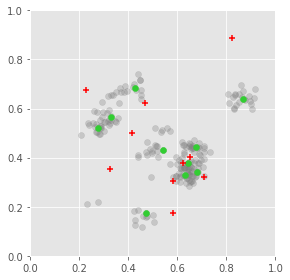

acceptance_rate=0.33051304, step_size=0.25000000
Energy diff: 0.01590765


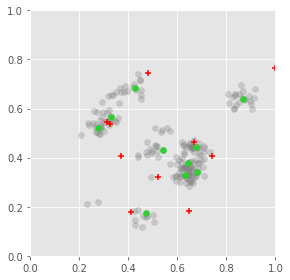

acceptance_rate=0.33172658, step_size=0.25000000
Energy diff: 0.00250635


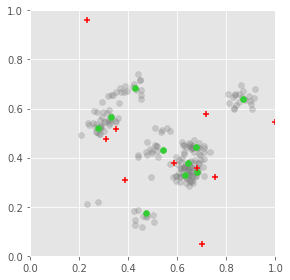

acceptance_rate=0.33094881, step_size=0.25000000
Energy diff: 0.00014429


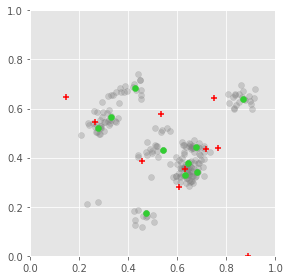

acceptance_rate=0.32977447, step_size=0.25000000
Energy diff: 0.00200734


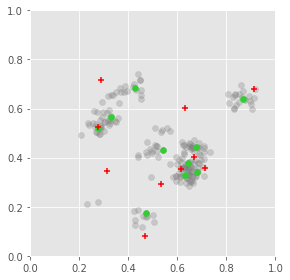

acceptance_rate=0.32909413, step_size=0.25000000
Energy diff: 0.01270205


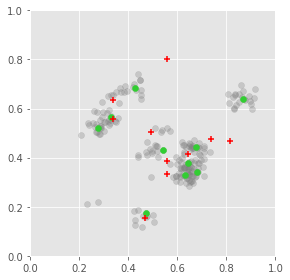

acceptance_rate=0.32704776, step_size=0.25000000
Energy diff: 0.01011055


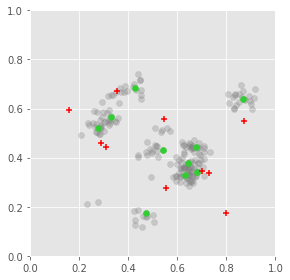

acceptance_rate=0.32687833, step_size=0.25000000
Energy diff: 0.01335278


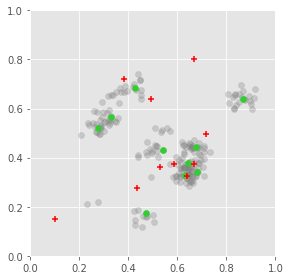

acceptance_rate=0.32660980, step_size=0.25000000
Energy diff: 0.00215528


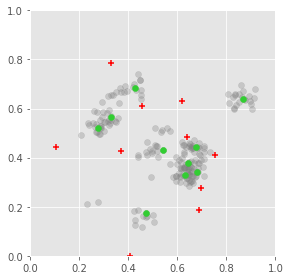

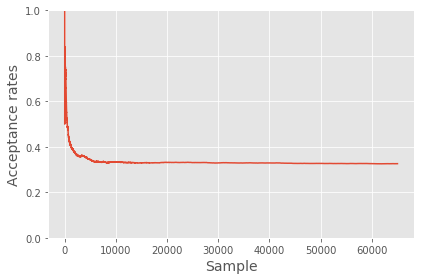

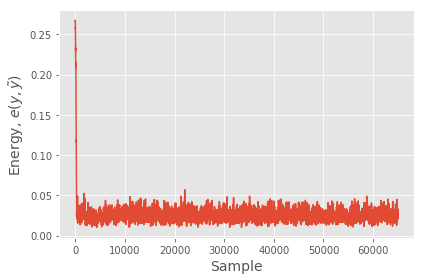

Acceptance rate: 0.326
percent steps that improved energy score: 0.162


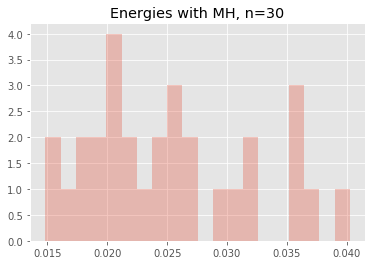


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 5000.000) = Exp(0.00021496)

Running chain. Length=65000, Burn=5000, Thin=2000
Difference factor: 4652.02

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: -0.00087300


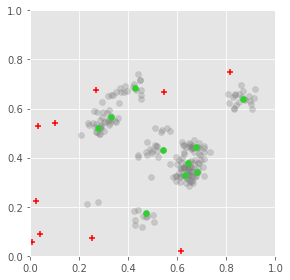

acceptance_rate=0.32195047, step_size=0.14388100
Energy diff: 0.00334747


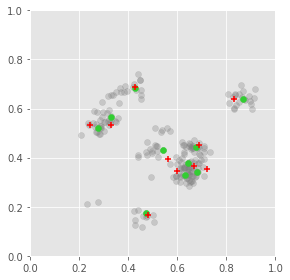

acceptance_rate=0.29797708, step_size=0.16000000
Energy diff: 0.00643943


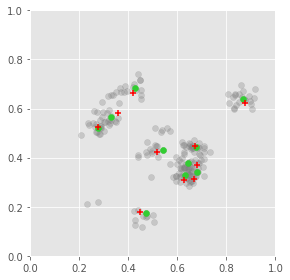

acceptance_rate=0.29511307, step_size=0.02147484
Energy diff: 0.00046213


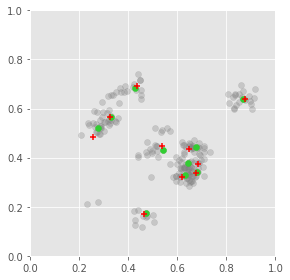

acceptance_rate=0.30256529, step_size=0.20548338
Energy diff: 0.00055380


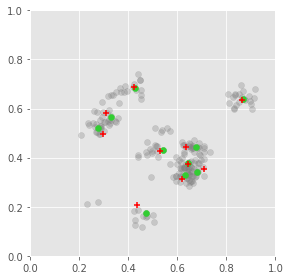

acceptance_rate=0.29842159, step_size=0.10240000
Energy diff: 0.00051707


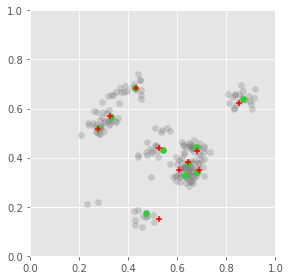

acceptance_rate=0.30135125, step_size=0.01139032
Energy diff: -0.00015402


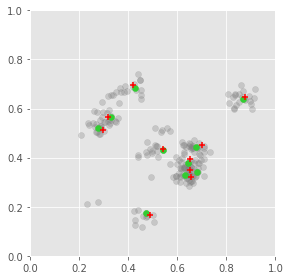

acceptance_rate=0.30390541, step_size=0.04818546
Energy diff: 0.00118709


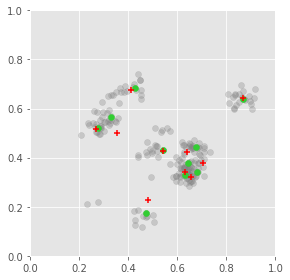

acceptance_rate=0.29907117, step_size=0.00879609
Energy diff: -0.00003113


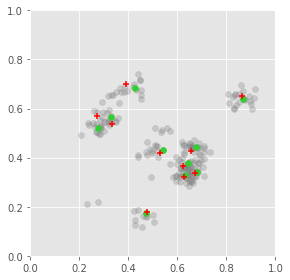

acceptance_rate=0.30011453, step_size=0.22481406
Energy diff: 0.00302728


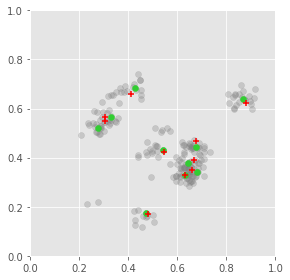

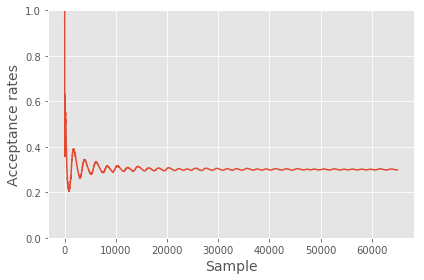

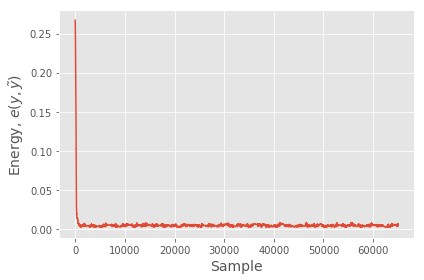

Acceptance rate: 0.299
percent steps that improved energy score: 0.152


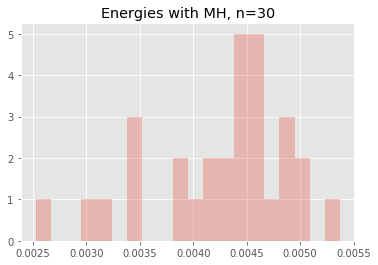

In [12]:
NUM_Y_TILDES = 30 
ALPHA_VALS = [50, 500, 5000]

energy_sensitivity = get_energy_sensitivity(NUM_SUPP, D, power=ENERGY_POWER)
print('energy sensitivity: {}'.format(energy_sensitivity))

sample_preproc_support_points = {}
sample_preproc_energies = {}
for ALPHA in ALPHA_VALS:
    (y_tildes_pre_SP,
     energies_pre_SP,
     _) = sample_sp_exp_mech(energy_sensitivity=energy_sensitivity, 
                             data=y_opt, 
                             num_support_points = NUM_SUPP, 
                             method='mh', 
                             num_y_tildes=NUM_Y_TILDES,
                             alpha=ALPHA, 
                             plot=1, 
                             save_dir=save_dir, 
                             power=ENERGY_POWER,
                             set_seed=True,
                             optimal_support_points=y_opt,
                             original_data=x
                            )
    
    total_energies_pre_SP = []
    for y_t in y_tildes_pre_SP:
        total_energies_pre_SP.append(energy(y_t, x, power=ENERGY_POWER)[0])

    sample_preproc_support_points[ALPHA] = y_tildes_pre_SP
    sample_preproc_energies[ALPHA] = total_energies_pre_SP


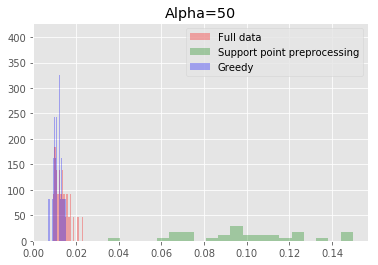

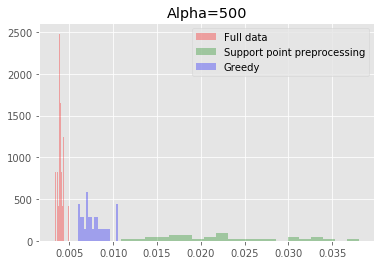

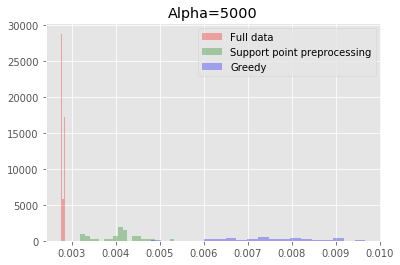

In [15]:
plt.hist(sample_direct_energies[50], bins=20, alpha=0.3, density=True, color='r', label='Full data')
plt.hist(sample_preproc_energies[50], bins=20, alpha=0.3, density=True, color='g', label='Support point preprocessing')
plt.hist(greedy_energies[50], bins=20, alpha=0.3, density=True, color='b', label='Greedy')
plt.legend()
plt.title('Alpha=50')
plt.show()

plt.hist(sample_direct_energies[500], bins=20, alpha=0.3, density=True, color='r', label='Full data')
plt.hist(sample_preproc_energies[500], bins=20, alpha=0.3, density=True, color='g', label='Support point preprocessing')
plt.hist(greedy_energies[500], bins=20, alpha=0.3, density=True, color='b', label='Greedy')
plt.legend()
plt.title('Alpha=500')
plt.show()

plt.hist(sample_direct_energies[5000], bins=20, alpha=0.3, density=True, color='r', label='Full data')
plt.hist(sample_preproc_energies[5000], bins=20, alpha=0.3, density=True, color='g', label='Support point preprocessing')
plt.hist(greedy_energies[5000], bins=20, alpha=0.3, density=True, color='b', label='Greedy')
plt.legend()
plt.title('Alpha=5000')
plt.show()

In [ ]:
np.mean(sample_direct_energies[5000])

In [ ]:
N

In [ ]:
x.shape

In [ ]:
NUM_SUPP

In [ ]:
get_energy_sensitivity(N, D, power=ENERGY_POWER)